In [175]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl

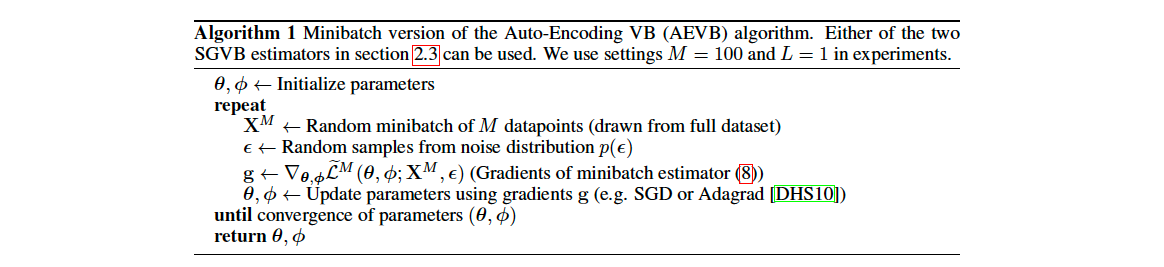

In [176]:
# m = 100, l = 1
# batch_size 100 samples 1
# adagrad 0.01, 0.02, 0.1
# inititialize N(0, 0.01)
# mnist 500 hidden units
# mlp gaussian outputs (encoder / decoder)
# log base 10 right?

generative (encoder) and variational approximation (decoder)
and switches later...

decoder with gaussian outputs, identical to encoder except - means (0, 1) w/ sigmoid  
params init N(0, 0.01)  
SGD on lower bound est. (alg 1) + small weight decay N(0, I) ~= approx. MAP est.  
Adagrad {0.01, 0.02, 0.1}  
minibatch = 100, samples = 1  
500 hidden units

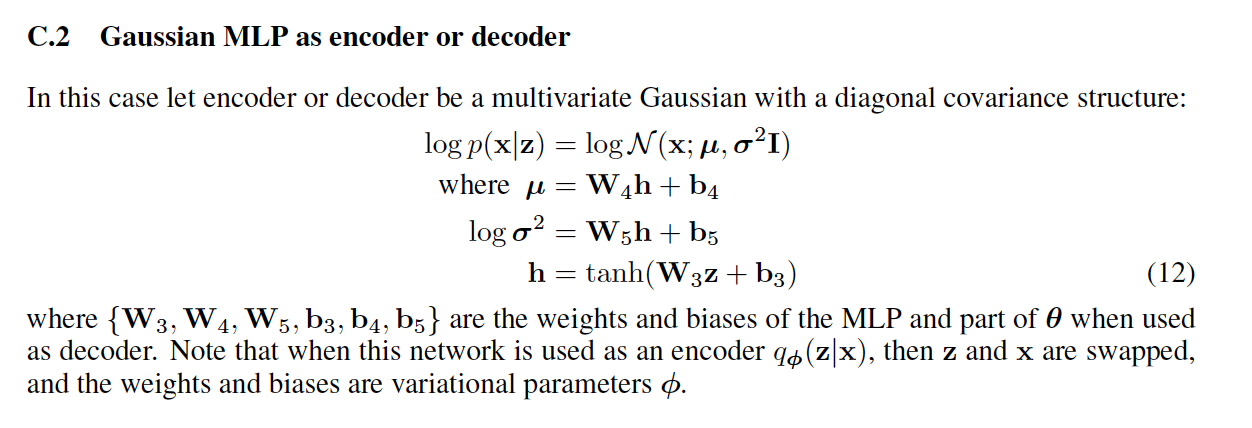

In [177]:
class GaussianMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=3):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = x.flatten()
        h = F.tanh(self.hidden(x))
        mean, log_var = self.mean(h), self.log_var(h)
        return self.sample(mean, log_var), mean, log_var
    
    def sample(self, mean, log_var):
        eps = torch.normal(0, 1, mean.shape)
        std = torch.exp(0.5 * log_var)
        return mean + std * eps

In [186]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=3):
        super().__init__()
        self.encoder = GaussianMLP(input_dim, hidden_dim, latent_dim)
        self.decoder = GaussianMLP(latent_dim, hidden_dim, input_dim)
    
    def forward(self, x):
        x = x.flatten()
        z, mean, log_var = self.encoder(x)
        x_prime, _, _ = self.decoder(z)
        return F.sigmoid(x_prime), mean, log_var

In [291]:
model = VAE(latent_dim=10)

In [188]:
x = dataset[0][0]
x.shape

torch.Size([1, 28, 28])

In [193]:
%timeit _ = model(x)

301 µs ± 3.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [245]:
def vae_loss(x, x_prime, mean, log_var):
    kl_div = (-1/2) * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
    recon = F.mse_loss(x_prime, x)
    # print(f"{kl_div=} {recon=}")
    return kl_div + recon

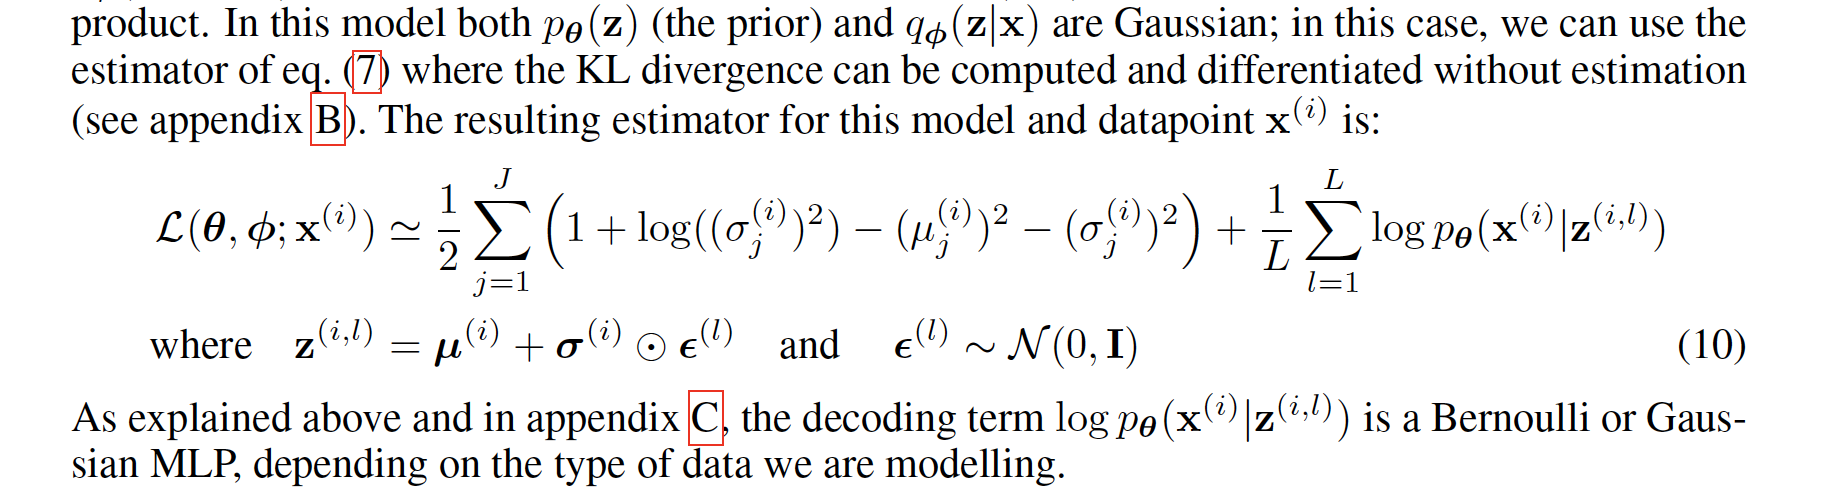

In [294]:
class LitVAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = VAE(latent_dim=10) 
        
    def training_step(self, batch, batch_idx):
        x, _ = batch
        # print(x.shape)
        x = x.flatten()
        # print(x.shape)
        x_, mean, log_var = self.forward(x)
        return vae_loss(x, x_, mean, log_var)
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [295]:
lit_vae = LitVAE()

In [296]:
dataset = MNIST(".", download=True, transform=transforms.ToTensor())
sub_idx = [idx for idx, target in enumerate(dataset.targets) if target in [0]]
sub_idx = sub_idx[:100]
sub = torch.utils.data.Subset(dataset, sub_idx)
train_loader = DataLoader(sub) # TODO: 100, random sample

In [297]:
len(train_loader)

100

In [298]:
trainer = pl.Trainer()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [300]:
trainer.fit(lit_vae, train_loader)


  | Name  | Type | Params
-------------------------------
0 | model | VAE  | 1.2 M 
-------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.774     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [255]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tF
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# At latent=10 epoch 20 100 Zeros

Predicting: 72it [00:00, ?it/s]

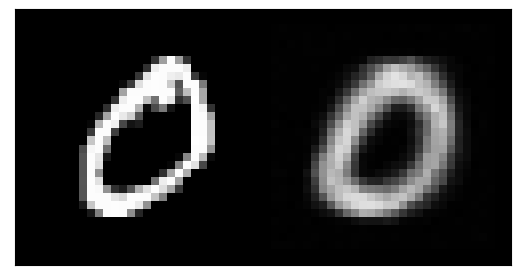

In [301]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(lit_vae, x)[0][0].reshape(1, 28, 28)]
grid = make_grid(imgs)
show(grid)

# At init

Predicting: 0it [00:00, ?it/s]

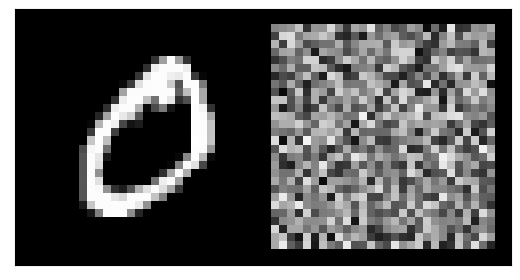

In [290]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(lit_vae, x)[0][0].reshape(1, 28, 28)]
grid = make_grid(imgs)
show(grid)

# At epoch 8 of 100 Zero images

Predicting: 42it [00:00, ?it/s]

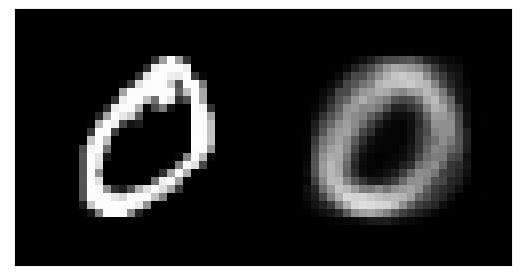

In [272]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(lit_vae, x)[0][0].reshape(1, 28, 28)]
grid = make_grid(imgs)
show(grid)

# At epoch 500 of 100 Zero images

Predicting: 4it [00:00, ?it/s]

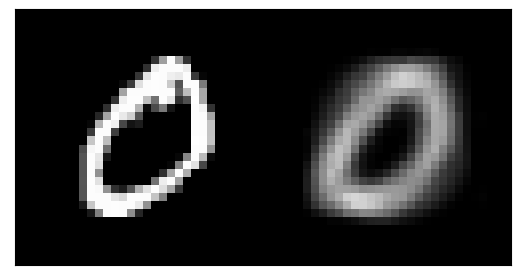

In [278]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(lit_vae, x)[0][0].reshape(1, 28, 28)]
grid = make_grid(imgs)
show(grid)

In [91]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(784, 10)
        self.decoder = nn.Linear(10, 784)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.flatten()
        x_ = self.forward(x)
        return F.mse_loss(x_, x)
    
    def forward(self, x):
        sz = x.shape
        x = x.flatten()
        return self.decoder(self.encoder(x)).reshape(sz)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [92]:
model = AutoEncoder()

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tF
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = tF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# At initialization

Predicting: 0it [00:00, ?it/s]

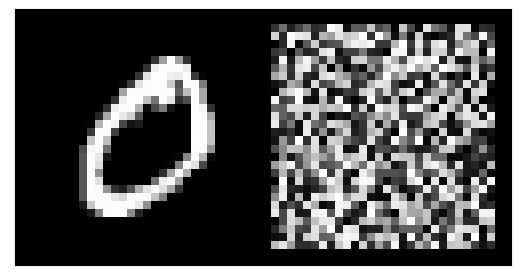

In [90]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(model, x)[0].unsqueeze(0)]
grid = make_grid(imgs)
show(grid)

# After 3 epochs 

Predicting: 4077it [00:00, ?it/s]

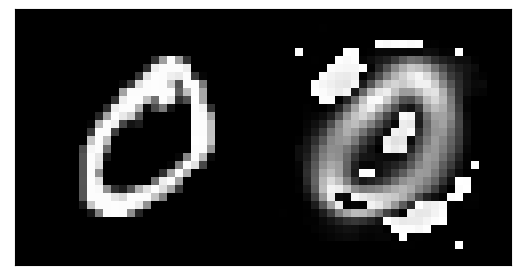

In [97]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(model, x)[0].unsqueeze(0)]
grid = make_grid(imgs)
show(grid)

# After 13 epochs 

Predicting: 2871it [00:00, ?it/s]

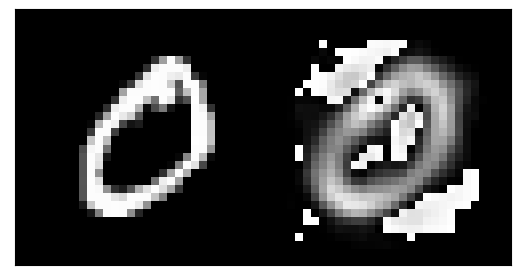

In [102]:
from torchvision.utils import make_grid
x = dataset[1][0]
imgs = [x, trainer.predict(model, x)[0].unsqueeze(0)]
grid = make_grid(imgs)
show(grid)

# Monte Carlo integration 
- stratified sampling
- importance sampling

Following examples from [this blog](https://boyangzhao.github.io/posts/monte-carlo-integration) and [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_integration).

https://github.com/blei-lab/edward/blob/master/edward/inferences/monte_carlo.py

In [79]:
import numpy as np
import math

In [349]:
def monte_carlo(f, a, b, n=10**6):
    dims = f.__code__.co_argcount
    x = np.random.uniform(a, b, (n, dims))
    y = f(*x.T)
    y_ = np.sum(y) / len(y)
    domain = (b - a) ** dims
    return domain * y_

$$
f(x) = x^2 \\
F(x) = \frac{1}{3} x^3
$$

In [372]:
def f(x):
    return x ** 2

def F(x):
    return (1 /3) * x ** 3

a, b = -2, 2

In [373]:
F(b) - F(a)

5.333333333333333

In [374]:
monte_carlo(f, a, b)

5.336790720652857

$$
f(x, y) = 
\begin{cases}
1 & x^2 + y^2 \le 1 \\
0 & \mathrm{else}
\end{cases}
$$

In [375]:
def f(x, y):
    return ((x ** 2 + y ** 2) <= 1).astype(int)
a, b = -1, 1

In [376]:
monte_carlo(f, -1, 1)

3.143992

Markov Chain Monte Carlo

- Metropolis-Hastings
- Metropolis (symmetric proposal distribution)
- Gibbs (conditional distribution sampling)

# VAE Paper notes

1. (Stochastic Gradient Variational Bayes) reparametrization of the variational lower bounds yields a simple differentiable unbiased estimator of the lower bounds

2. (Auto-Encoding Variational Bayes) using SGVB estimator to optimize a recognition model that allows us to perform very efficient approximate posterior inference using simple ancestral sampling

When neural network is used for the recognition model, we arrive at the *variational auto-encoder.*

we like to maximum likelihood (ML) or maximum a posteriori (MAP) inference on the (global parameters)

$p_{\theta}(z)p_{\theta}(x|z)$ - generative model  
$q_{\phi}(z|x)$ - variational approximation to the intractable posterior $p_{\theta}(z|x)$  
$\phi$ - variational parameters  
$\theta$ - generative model parameters  

1. a value $z^{(i)}$ is generated from some prior distribution $p_{\theta^{*}}(z)$ (prior)

2. a value $x^{(i)}$ is generated from some conditional distribution $p_{\theta^{*}}(x|z)$ (likelihood)

Needed for:
1. intractability of marginal likelihood, posterior density, mean-field variational bayes - many cases, e.g. neural networks
2. large dataset

unobserved variables $z$ latent representation or code -> encoder  
$p_{\theta}(x|z)$  

x -> encoder -> distribution over the possible values of the code $z$ from which the datapoint $x$ could have been generated  
z -> decoder -> distribution over the possible corresponding values of $x$



marginal likelihood sum over the marginal likelihoods of individual datapoints

$\sum_{i=1}^{N} \mathrm{log}p_{\theta}(x^{(i)})$

marginal likelihood = KL divergence (encoder, posterior) + variational lower bound of marginal likelihood

\begin{align*}
q(z | x) &\;\mathrm{encoder}\; \phi & z = q_{\phi}(x) \\
p(x | z) &\;\mathrm{decoder, generative\; model}\; \theta & x' = p_{\theta}(z) \\ 
\end{align*}

prior      - p(z)  
likelihood - p(x | z)  
posterior  - p(z | x)  

sample from p(z)  
sample? from conditional p(x | z=z) 

kl quantify distance. KL(X | Y) how much information lost if Y respresents X

minimize KL(encoder | decoder) how much information lost if decoder represents encoder

choose theta to maximimize probability "generating real data samples" p(x)
    -> maximize log prob
    -> calc p(x) difficult = integral over P(x | z)p(z)

metrics 
  - cross entropy with sigmoid
  - mse simple

relative entropy 

expectation of the logarithmic difference between probabilities

\begin{align*}
D_{KL}(P || Q) = \int_{\infty}^{\infty} p(x) \mathrm{log}\left(\frac{p(x)}{q(x)}\right)dx
\end{align*}

divergence of $P$ from $Q$